<a href="https://colab.research.google.com/github/antunesdantass/recuperacao-de-informa-o/blob/master/ePol_Antunes_e_V%C3%A9lmer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este notebook tem como objetivo demonstrar técnicas de classificação de texto usando a biblioteca sklearn e os algoritmos Regressão Logística, Árvore de Decisão e SVM. O objetivo é analisar quais destes é mais eficiente. Os dados de treinamento e teste serão os mesmos para os três algoritmos. Este trabalho é baseado em um tutorial do blog Towars Data Science, disponível [aqui](https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568).


Os dados que utilizaremos nesse tutorial são de perguntas feitas no site StackOverflow. A ideia é separar as perguntas de acordo com a tecnologia/linguagem de programação da sua tag.

In [6]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

df = pd.read_csv('https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv')
df = df[pd.notnull(df['tags'])]
print(df.head(10))
print(df['post'].apply(lambda x: len(x.split(' '))).sum())

                                                post           tags
0  what is causing this behavior  in our c# datet...             c#
1  have dynamic html load as if it was in an ifra...        asp.net
2  how to convert a float value in to min:sec  i ...    objective-c
3  .net framework 4 redistributable  just wonderi...           .net
4  trying to calculate and print the mean and its...         python
5  how to give alias name for my website  i have ...        asp.net
6  window.open() returns null in angularjs  it wo...      angularjs
7  identifying server timeout quickly in iphone  ...         iphone
8  unknown method key  error in rails 2.3.8 unit ...  ruby-on-rails
9  from the include  how to show and hide the con...      angularjs
10286120


Como desejamos classificar os dados, é interessante observar a distribuição dos dados por classe, já que vimos na apresentação que a maioria dos modelos pode sofrer de overfitting quando há uma classe dominante.

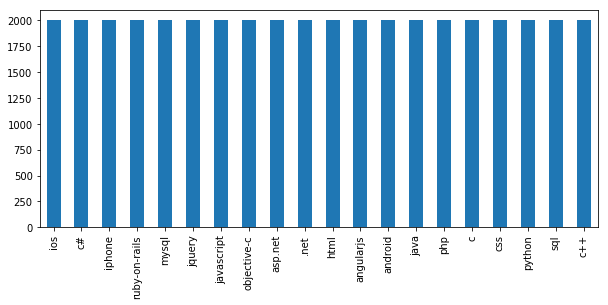

In [3]:
my_tags = ['java','html','asp.net','c#','ruby-on-rails','jquery','mysql','php','ios','javascript','python','c','css','android','iphone','sql','objective-c','c++','angularjs','.net']
plt.figure(figsize=(10,4))
df.tags.value_counts().plot(kind='bar');

A primeira etapa antes de iniciar a classificação é preparar os dados. Como estamos trabalhando com textos extraídos de uma página web, é importante remover quaisquer resquícios de linguagem de marcação e termos que não são úteis. Vamos olhar como estão os dados:

In [4]:
def print_plot(index):
    example = df[df.index == index][['post', 'tags']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

print_plot(10)

when we need interface c# <blockquote>    <strong>possible duplicate:</strong><br>   <a href= https://stackoverflow.com/questions/240152/why-would-i-want-to-use-interfaces >why would i want to use interfaces </a>   <a href= https://stackoverflow.com/questions/9451868/why-i-need-interface >why i need interface </a>    </blockquote>     i want to know where and when to use it     for example    <pre><code>interface idemo {  // function prototype  public void show(); }  // first class using the interface class myclass1 : idemo {  public void show()  {   // function body comes here   response.write( i m in myclass );  }  }  // second class using the interface class myclass2 : idemo {  public void show()   {   // function body comes here   response.write( i m in myclass2 );   response.write( so  what  );  } </code></pre>   these two classes has the same function name with different body. this can be even achieved without interface. then why we need an interface where and when to use it
Tag:

Como visto acima, no meio do texto há muito "lixo". Tags HTML, trechos de código. Nada disso é interessante para a classificação e deve ser removido. Essa etapa é conhecida como pré-processamento dos documentos e é independente da maneira como iremos classificá-los.

In [9]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df['post'] = df['post'].apply(clean_text)
print_plot(10)

need interface c# possible duplicate would want use interfaces need interface want know use example interface idemo function prototype public void show first class using interface class myclass1 idemo public void show function body comes responsewrite myclass second class using interface class myclass2 idemo public void show function body comes responsewrite myclass2 responsewrite two classes function name different body even achieved without interface need interface use
Tag: c#


O texto acima é exatamente o mesmo que estava antes da "limpeza". Dessa vez, sem trechos de códigos e totalmente limpo. Uma métrica interessante é observar o tamanho do corpus:

In [10]:
df['post'].apply(lambda x: len(x.split(' '))).sum()

3424297

Nosso corpus tem mais de três milhões de palavras. É um número considerável. Agora, vamos criar os dados de treinamento e teste. Isso pode ser feito com a bilbioteca Scikit Learn.

In [0]:
X = df.post
y = df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

Depois de definidos os conjuntos de treinamento e teste, vamos treinar os algorítmos. O primeiro será a regressão logística.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

logreg = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression(n_jobs=1, C=1e5)),
              ])
logreg.fit(X_train, y_train)

# %%time
from sklearn.metrics import classification_report
y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))
# view raw


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.78175
               precision    recall  f1-score   support

         java       0.70      0.62      0.66       613
         html       0.91      0.91      0.91       620
      asp.net       0.97      0.94      0.95       587
           c#       0.77      0.77      0.77       586
ruby-on-rails       0.77      0.81      0.79       599
       jquery       0.59      0.58      0.59       589
        mysql       0.78      0.75      0.76       594
          php       0.82      0.85      0.83       610
          ios       0.69      0.71      0.70       617
   javascript       0.61      0.59      0.60       587
       python       0.64      0.63      0.63       611
            c       0.82      0.83      0.83       594
          css       0.78      0.78      0.78       619
      android       0.84      0.85      0.84       574
       iphone       0.80      0.83      0.82       584
          sql       0.65      0.64      0.65       578
  objective-c       0.82      0.85      0.83   

In [15]:
from sklearn.tree import DecisionTreeClassifier
dectree = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', DecisionTreeClassifier()),
              ])

dectree.fit(X_train, y_train)
y_pred = dectree.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.6911666666666667
               precision    recall  f1-score   support

         java       0.55      0.58      0.56       613
         html       0.83      0.77      0.80       620
      asp.net       0.91      0.87      0.89       587
           c#       0.68      0.65      0.67       586
ruby-on-rails       0.69      0.75      0.72       599
       jquery       0.43      0.40      0.41       589
        mysql       0.59      0.60      0.59       594
          php       0.73      0.75      0.74       610
          ios       0.57      0.56      0.56       617
   javascript       0.52      0.52      0.52       587
       python       0.58      0.55      0.56       611
            c       0.73      0.76      0.74       594
          css       0.68      0.71      0.69       619
      android       0.76      0.76      0.76       574
       iphone       0.76      0.79      0.78       584
          sql       0.58      0.56      0.57       578
  objective-c       0.78      0.72  

In [16]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7895833333333333
               precision    recall  f1-score   support

         java       0.73      0.67      0.70       613
         html       0.84      0.94      0.89       620
      asp.net       0.88      0.95      0.92       587
           c#       0.81      0.80      0.80       586
ruby-on-rails       0.73      0.89      0.80       599
       jquery       0.77      0.39      0.52       589
        mysql       0.81      0.69      0.74       594
          php       0.71      0.95      0.81       610
          ios       0.83      0.57      0.67       617
   javascript       0.72      0.58      0.64       587
       python       0.71      0.65      0.68       611
            c       0.79      0.88      0.83       594
          css       0.77      0.79      0.78       619
      android       0.84      0.86      0.85       574
       iphone       0.82      0.81      0.81       584
          sql       0.70      0.68      0.69       578
  objective-c       0.81      0.90  